In [43]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# choose whether to work on a remote machine
location = "remote"
if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

# Data storage setup

In [69]:
# import relevant packages

from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np
# import math as m
# import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import wandb
from tqdm import tqdm
from sklearn import model_selection
from sklearn.preprocessing import normalize
from scipy.interpolate import interp2d
from sklearn.utils import class_weight
from scipy.ndimage import gaussian_gradient_magnitude
import xbatcher

import rasterio
from rasterio.plot import show
import rioxarray as rio

from bs4 import BeautifulSoup
import requests


#issues with numpy deprecation in pytorch_env
from coralshift.processing import spatial_data
from coralshift.utils import file_ops, directories
from coralshift.plotting import spatial_plots, model_results
from coralshift.dataloading import data_structure, climate_data, bathymetry, reef_extent

In [74]:
ds_man = data_structure.MyDatasets()
ds_man.set_location(location)

## Specify your area of interest

The availability of high-resolution (30m) bathymetric data means that areas of interest are currently confided to 4 areas on the Great Barrier Reef (GBR). The following code generates a geoJSON file specifying which area (A-D) you'd like to investigate:

| Reef Area Name                	| Latitudes 	| Longitudes 	|
|-------------------------------	|-----------	|------------	|
| Great Barrier Reef A 2020 30m 	| 10-17°S   	| 143-147°E  	|
| Great Barrier Reef B 2020 30m 	| 16-23°S   	| 144-149°E  	|
| Great Barrier Reef C 2020 30m 	| 18-24°S   	| 148-154°E  	|
| Great Barrier Reef D 2020 30m 	| 23-29°S   	| 150-156°E  	|


Download your required area from here: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/115066

Due to the computational load required to run ML models on such a high resolution data, bathymetric data is currently upsampled to 4km grid cells and areas are limited to a quarter of the GBR's total area.

In [47]:
# choose resolution (must be above 1000m): in metres
target_resolution = 4000

# convert distance to degrees:
_,_,av_degrees = spatial_data.distance_to_degrees(target_resolution)
print(f"Data will be downsampled to {av_degrees} (~{target_resolution}m).")

Data will be downsampled to 0.03691157541051416 (~4000m).


## Bathymetry

In [48]:
# select your area
area_name = "A"

# download .tif if not downloaded aready
reef_areas = bathymetry.ensure_bathymetry_downloaded(area_name)
# cast tif to processed xarray
xa_bath = spatial_data.tif_to_xarray(
    directories.get_bathymetry_datasets_dir() / reef_areas.get_filename(area_name), reef_areas.get_xarray_name(area_name)
    )

# upsample to specified resolution
xa_bath_upsampled = spatial_data.upsample_xarray_to_target(xa_bath, target_resolution=av_degrees)

Already exists: /lustre_scratch/orlando-code/datasets/bathymetry/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif


/lustre_scratch/orlando-code/coralshift/coralshift/processing/spatial_data.py:995: UserWarning: rename 'band' to 'band' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  {coord: rename_mapping.get(coord, coord) for coord in xa_d.coords}


In [49]:
# TODO: better visualisation, investigate speed of plotting. Cell seems not to load when calling values...
# xa_bath_upsampled.plot()

## Coral ground truth: Allen Coral Atlas


There is currently no API for accessing data directly from your local machine. Please follow the instructions* below:
1. Make an account on the [Allen Coral Atlas](https://allencoralatlas.org/atlas/#6.00/-13.5257/144.5000) webpage
2. Generate a geojson file using the code cell below (generated in the `reef_baseline` directory)

*Instructions correct as of 30.06.23

In [76]:
# generate geojson file in reef_baseline directory for download from the Allen Coral Atlas
geojson_path = reef_extent.generate_area_geojson(
    area_class = reef_areas, area_name=area_name, save_dir=directories.get_reef_baseline_dir())

3. Upload the geojson file via:

    \> My Areas > Upload a GeoJSON or KML file
4. Wait for the area to be processed, and select "Benthic Map (OGC GeoPackage (.gpkg))". Sign the terms and conditions 
and select "Prepare Download". After ~two minutes a sequence of emails will arrive notifying you that your download is ready.
5. Download the file and unzip it using a unzipping utility. Then,
    - add the `benthic.geojson` to the `reef_baseline` directory
    
    
6. Continue with the subsequent code cells.

----

You have now downloaded:

**`benthic.gpkg`**

Set of shapely objects labelled with reef class:

| Class           	| Number of polygons 	|
|-----------------	|--------------------	|
| Coral/Algae     	| 877787             	|
| Rock            	| 766391             	|
| Rubble          	| 568041             	|
| Sand            	| 518805             	|
| Microalgal Mats 	| 27569              	|

In [149]:
benthic_df = file_ops.check_pkl_else_read_gpkg(directories.get_reef_baseline_dir(), filename = "benthic.pkl")
benthic_df.head()

Reading /lustre_scratch/orlando-code/datasets/reef_baseline/benthic.pkl...
benthic read from benthic.pkl


,class,geometry
0,Coral/Algae,"POLYGON ((143.26813 -11.48797, 143.26817 -11.4..."
1,Sand,"POLYGON ((143.26862 -11.49201, 143.26867 -11.4..."
2,Sand,"POLYGON ((143.26718 -11.49323, 143.26736 -11.4..."
3,Sand,"POLYGON ((143.26930 -11.49323, 143.26934 -11.4..."
4,Sand,"POLYGON ((143.26889 -11.49502, 143.26894 -11.4..."


### Rasterize polygons

Rasterized arrays are necessary to process the geospatial data e.g. to align different gridcells. Doing this locally through rasterio requires significant compute. A JavaScript file for use with Google Earth Engine (GEE) is provided in the `coralshift` repo as an alternative. Visit [this page](https://developers.google.com/earth-engine/guides/getstarted) for imformation regarding setting up a GEE account and getting started.


In [222]:
gdf_coral.total_bounds

array([143.26632196, -11.55516425, 143.49652416, -11.47810779])

In [166]:
# process df to GeoPandasDf
gdf_coral = reef_extent.process_benthic_pd(benthic_df)
# save as shapely file for rasterisation
save_path = directories.get_reef_baseline_dir() / "coral_algae_gt.shp"
if not save_path.is_file():
    gdf_coral.to_file(save_path, driver="ESRI Shapefile")
else:
    print(f"File at {save_path} already exists.")


In [172]:
a,s,d,f=gdf.total_bounds

In [174]:
d-a

0.23020220299997618

In [192]:
np.mean((xmax, xmin))

143.3814230575

In [195]:
print(xmin, xmax, ymin, ymax)

143.266321956 143.496524159 -11.555164247 -11.478107786


In [217]:
lengths

(8568.299363407006, 25081.994534457357)

In [214]:
len(gdf)

15788

In [224]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize

# Read the shapefile using geopandas
shapefile_path = 'lustre_scratch/datasets/reef_baseline/benthic.shp'
gdf = gpd.read_file(shapefile_path)

# Prepare raster parameters
# pixel_size = 1.0  # Desired pixel size in the raster/
lon_min, lat_min, lon_max, lat_max = gdf.total_bounds  # Extent of the shapefile

lengths = spatial_data.degrees_to_distances(lat_max-lat_min, lon_max-lon_min, np.mean((lat_min, lat_max)), np.mean((lon_max, lon_min)))

width = int(lengths[0])
height = int(lengths[1])
# width_pixel = 

# width = int((lon_max - lon_min) / pixel_size)
# height = int((lat_max - lat_min) / pixel_size)
transform = rasterio.transform.from_origin(lon_min, lat_max, 5, 5)  # Coordinate transformation

# Create an empty raster array
raster_array = np.zeros((height, width), dtype=np.uint8)  # Use the desired dtype

# Rasterize each polygon in the shapefile
for geom, value in tqdm(zip(gdf.geometry, gdf['class_val']), total=len(gdf), des = "Rasterizing polygons"):
    out = rasterize(shapes=[(geom, value)], out=raster_array, transform=transform)



# shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['class_val']))  # Specify the column to rasterize
# out = rasterize(shapes=shapes, out=raster_array, transform=transform)


KeyboardInterrupt: 

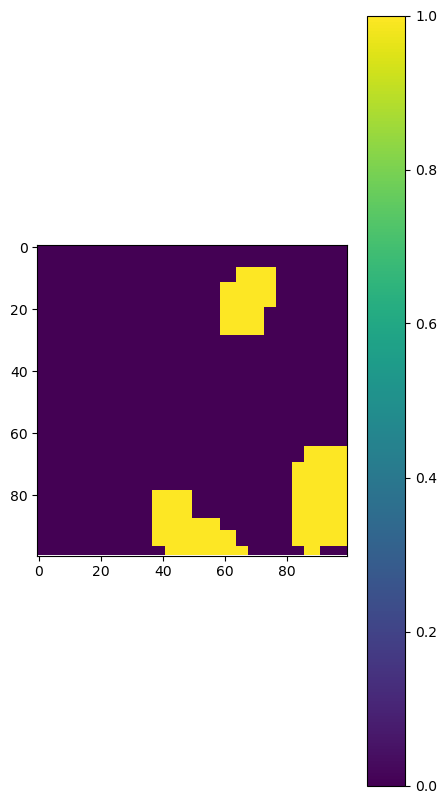

In [225]:
f,a = plt.subplots(figsize=[5,10])
im = a.imshow(out[1900:2000,:100])
f.colorbar(im)

## Global Ocean Reanalysis

In [51]:
ds_man = data_structure.MyDatasets()
ds_man.set_location(location)

noaa_features = ['mlotst', 'bottomT', 'uo', 'so', 'zos', 'thetao', 'vo']

# TODO: transparency in preprocessing to get to this (probably split into separate gt datarray)
ds_man.add_dataset(
    "monthly_climate_1_12", xa.open_dataset(
        ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")
)

ds_man.add_datasets(
    ["monthly_climate_1_12_X", "monthly_climate_1_12_y"], 
        spatial_data.process_xa_ds_for_ml(ds_man.get_dataset("monthly_climate_1_12"), 
        feature_vars=noaa_features, gt_var="coral_algae_1-12_degree")
)

# TODO: handle depth
ds_man.add_dataset(
    "daily_climate_1_12", spatial_data.generate_and_add_gt_to_xa_d(xa.open_dataset(
        Path(ds_man.get_location() / "global_ocean_reanalysis/daily_means/dailies_combined.nc")).isel(depth=0),
        ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"])
)

# TODO: streamline checking and saving process
daily_climate_1_12_X_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_X.npy"
# if daily_climate_1_12_X numpy array doesn't exist, generate and save
if not file_ops.check_file_exists(filepath = daily_climate_1_12_X_file_path):
    daily_climate_1_12_X = spatial_data.process_xa_ds_for_ml(ds_man.get_dataset("daily_climate_1_12"),
        feature_vars = noaa_features)
    np.save(daily_climate_1_12_X_file_path, daily_climate_1_12_X) 
    ds_man.add_dataset("daily_climate_1_12_X", np.load(daily_climate_1_12_X_file_path))
else:
    ds_man.add_dataset("daily_climate_1_12_X", np.load(daily_climate_1_12_X_file_path))

daily_climate_1_12_padded_1_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_padded_1.nc"
# if daily_climate_1_12_padded_1 .nc file doesn't exist, generate and save
if not file_ops.check_file_exists(filepath = daily_climate_1_12_padded_1_file_path):
    daily_climate_1_12_padded_1 = spatial_data.spatially_buffer_timeseries(
        ds_man.get_dataset("daily_climate_1_12"), buffer_size=1, exclude_vars = ["spatial_ref", "coral_algae_gt"])
    daily_climate_1_12_padded_1.to_netcdf(filepath = daily_climate_1_12_padded_1_file_path)
    ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))
else:
    ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))

# add in ground truth to padded
ds_man.add_dataset(
    "daily_climate_1_12_padded_1_gt", spatial_data.generate_and_add_gt_to_xa_d(
        ds_man.get_dataset("daily_climate_1_12_padded_1"),
        ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"])
)

ds_man.add_dataset(
    "bathymetry_A", rio.open_rasterio(
        rasterio.open(ds_man.get_location() / "bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"),
        ).rename("bathymetry_A").rename({"x": "longitude", "y": "latitude"})
)

RasterioIOError: lustre_scratch/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif: No such file or directory

In [ ]:
ds_man_ml = data_structure.MyDatasets()
ds_man_ml.set_location(location)
